# Evaluating the processing pipeline

Goal
- Evaluate and safe-check the processing pipeline


Visualize
- Each data series for 3 rain events
- Each data series for each error type
- Additionally:
    - For each system?
    - When changing systems?
- Keep the raw data in the background



Comparison
- The raw, provided clean, and the new processed data
- Average data gap counts and average size
- How much is missing, and how much is due to errors
- Average value?






---
# TODO:

- [ ] Visualize events from each system?

---


### Initialize

In [1]:
import os
import time
import copy
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import nexusformat.nexus as nx
import pickle
import json
from tqdm import tqdm
import datetime
import matplotlib.dates as mdates
from datetime import timedelta
import matplotlib.gridspec as gridspec




from fault_management_uds.data.HDF5_functions import print_tree, load_dataframe_from_HDF5
from fault_management_uds.data.process import remove_nans_from_start_end

from fault_management_uds.modeling.classify_rain import classify_rain_events
from fault_management_uds.plots import get_segment_start_end_color, set_meaningful_xticks
from fault_management_uds.config import indicator_2_meta, bools_2_meta, error_indicators, natural_sensor_order
bools_columns = ['ffill'] + error_indicators


from fault_management_uds.config import PROJ_ROOT
from fault_management_uds.config import DATA_DIR, RAW_DATA_DIR, INTERIM_DATA_DIR, PROCESSED_DATA_DIR, EXTERNAL_DATA_DIR
from fault_management_uds.config import MODELS_DIR, REPORTS_DIR, FIGURES_DIR, REFERENCE_DIR


from fault_management_uds.data.load import import_external_metadata, import_metadata
from fault_management_uds.data.load import load_data_period, filenames_based_on_period, provided_2_full_range, get_event
from fault_management_uds.data.format import create_individual_indicators, create_indicator


# set random seed
seed = 42
np.random.seed(seed)


2024-11-10 12:33:54.791 | INFO     | fault_management_uds.config:<module>:11 - PROJ_ROOT path is: /Users/arond.jacobsen/Documents/GitHub/fault_management_uds


In [2]:
runtime_start = time.time()

In [3]:
data_file_path = PROCESSED_DATA_DIR / 'Bellinge.h5'

# Raw sensor path
raw_sensor_path = RAW_DATA_DIR / 'Bellinge' / 'sensor-data'

# Raw rain path
raw_rain_path = RAW_DATA_DIR / 'Bellinge' / 'rain-gauge-data'

# Provided sensor path
provided_processed_path = EXTERNAL_DATA_DIR / 'Bellinge' / 'sensor-data' / '2_cleaned_data'


In [4]:
f = print_tree(data_file_path)

root
├── combined_data
│   ├── clean
│   │   ├── columns
│   │   ├── data
│   │   └── timestamps
│   └── raw
│       ├── columns
│       ├── data
│       └── timestamps
└── single_series
    ├── rain_gauge_data
    │   ├── 5425
    │   │   ├── columns
    │   │   ├── data
    │   │   └── timestamps
    │   └── 5427
    │       ├── columns
    │       ├── data
    │       └── timestamps
    └── sewer_data
        ├── G71F04R_Level1
        │   ├── bools
        │   │   ├── columns
        │   │   ├── data
        │   │   └── timestamps
        │   ├── clean
        │   │   ├── columns
        │   │   ├── data
        │   │   └── timestamps
        │   └── raw
        │       ├── columns
        │       ├── data
        │       └── timestamps
        ├── G71F04R_Level2
        │   ├── bools
        │   │   ├── columns
        │   │   ├── data
        │   │   └── timestamps
        │   ├── clean
        │   │   ├── columns
        │   │   ├── data
        │   │   └── timestamps
        │ 

In [5]:
external_metadata = import_metadata(REFERENCE_DIR / 'external_metadata.csv')
metadata = import_metadata(REFERENCE_DIR / 'sensor_metadata.csv')

In [6]:
def get_complete_sensor_data(sensor_name, start, end, raw_rain_path, raw_sensor_path, provided_processed_path, external_metadata, data_file_path):

    event_data = get_event(sensor_name, start, end, raw_rain_path, raw_sensor_path, provided_processed_path, external_metadata, data_file_path)

    indicator = create_indicator(event_data['processed_clean_sensor'], 'value', event_data['bools'], error_indicators, start, end)
    event_data['indicator'] = indicator
    individual_indicators = create_individual_indicators(event_data['indicator'].value, indicator_2_meta, event_data['bools'][bools_columns], bools_2_meta)
    
    # and for provided
    if event_data['provided_processed'].empty:
        provided_indicator = pd.DataFrame(index=event_data['processed_clean_sensor'].index, columns=['value'])
        provided_individual_indicators = None
    else:
        provided_indicator = create_indicator(event_data['provided_processed'], 'depth_s', event_data['provided_processed'], error_indicators, start, end)
        provided_individual_indicators = create_individual_indicators(provided_indicator.value, indicator_2_meta, event_data['provided_processed'][bools_columns], bools_2_meta)
    
    event_data['provided_indicator'] = provided_indicator
    
    unit = metadata[metadata['IdMeasurement'] == sensor_name]['UnitAlias'].values[0]
    return event_data, individual_indicators, provided_individual_indicators, unit


# def filter_complete_sensor_data(start, end, event_data, individual_indicators, provided_individual_indicators):
#     # copy data
#     _event_data, _individual_indicators, _provided_individual_indicators = copy.deepcopy(event_data), copy.deepcopy(individual_indicators), copy.deepcopy(provided_individual_indicators)
    
#     # Filter data based on start and end
#     for data_name in _event_data.keys():
#         if _event_data[data_name].empty:
#             continue    
#         # get the location of the start and end
#         _start = np.searchsorted(_event_data[data_name].index, start, side='right')
#         _end = np.searchsorted(_event_data[data_name].index, end, side='left')
#         _event_data[data_name] = _event_data[data_name].iloc[_start:_end]

#     # Filter individual indicators
#     if _event_data['processed_clean_sensor'].empty:
#         return None, None, None

        
#     #time_index = event_data['processed_clean_sensor'].index
#     time_index = event_data['indicator'].index
#     # get start and end index
#     # get the location of the start and end
#     _start = np.searchsorted(time_index, start, side='right')
#     _end = np.searchsorted(time_index, end, side='left')
#     for indicator_name in _individual_indicators.keys():
#         _individual_indicators[indicator_name]['indicator'] = _individual_indicators[indicator_name]['indicator'][_start:_end]

#     if _event_data['provided_processed'].empty:
#         return _event_data, _individual_indicators, None
#     for indicator_name in _provided_individual_indicators.keys():
#         _provided_individual_indicators[indicator_name]['indicator'] = _provided_individual_indicators[indicator_name]['indicator'][_start:_end]


#     return _event_data, _individual_indicators, _provided_individual_indicators

def filter_complete_sensor_data(start, end, event_data, individual_indicators, provided_individual_indicators):
    # Copy data
    _event_data = copy.deepcopy(event_data)
    _individual_indicators = copy.deepcopy(individual_indicators)
    _provided_individual_indicators = copy.deepcopy(provided_individual_indicators)

    # Filter data based on start and end
    for data_name in _event_data.keys():
        if _event_data[data_name].empty:
            continue    
        # Get the location of the start and end
        _start = np.searchsorted(_event_data[data_name].index, start, side='left')
        _end = np.searchsorted(_event_data[data_name].index, end, side='right')
        _event_data[data_name] = _event_data[data_name].iloc[_start:_end]

    # Filter individual indicators
    if _event_data['processed_clean_sensor'].empty:
        return None, None, None

    # Time index for individual indicators
    time_index = event_data['indicator'].index
    # Get start and end index
    _start = np.searchsorted(time_index, start, side='left')
    _end = np.searchsorted(time_index, end, side='right')
    for indicator_name in _individual_indicators.keys():
        _individual_indicators[indicator_name]['indicator'] = _individual_indicators[indicator_name]['indicator'][_start:_end]

    if _event_data['provided_processed'].empty:
        return _event_data, _individual_indicators, None
    for indicator_name in _provided_individual_indicators.keys():
        _provided_individual_indicators[indicator_name]['indicator'] = _provided_individual_indicators[indicator_name]['indicator'][_start:_end]

    return _event_data, _individual_indicators, _provided_individual_indicators



## Visualize functions

In [ ]:
from fault_management_uds.plots import visualize_indicator_dict, visualize_error_span

In [ ]:
def visualize_sensor_event(event_data, individual_indicators, sensor_name, unit, start, end):
    """
    Visualize the sensor event
    """

    # 3 subplots; rain, sensor, errors
    fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True, dpi=200)

    raw_alpha = 0.4
    raw_width = 4.5
    alpha = 1
    ##############################
    # Rain data; constant
    ##############################
    axs[0].plot(event_data['raw_5425'].index, event_data['raw_5425']['value'], 
        label='Raw 5425', color='cornflowerblue', 
        linewidth=raw_width, linestyle='', 
        marker='o', markersize=3, alpha=raw_alpha)
    axs[0].plot(event_data['processed_5425'].index, event_data['processed_5425']['value'], 
        label='Processed 5425', color='darkblue', 
        linewidth=1, linestyle='-', 
        marker='o', markersize=1, alpha=alpha)

    axs[0].plot(event_data['raw_5427'].index, event_data['raw_5427']['value'], 
        label='Raw 5427', color='mediumorchid', 
        linewidth=raw_width, linestyle='', 
        marker='o', markersize=3, alpha=raw_alpha)
    axs[0].plot(event_data['processed_5427'].index, event_data['processed_5427']['value'], 
        label='Processed 5427', color='purple', 
        linewidth=1, linestyle='-', 
        marker='o', markersize=1, alpha=alpha)

    axs[0].set_title('Rain data', fontsize=12)
    axs[0].set_ylabel('Rain (mm)')
    # place legend the best spot
    axs[0].legend(loc='upper left')


    ##############################
    # Sensor data
    ##############################

    axs[1] = visualize_error_span(axs[1], individual_indicators['No Data'], start, end, adjust="half-point")
    axs[1] = visualize_error_span(axs[1], individual_indicators['Erroneous'], start, end, adjust="half-point")


    axs[1].plot(event_data['raw_sensor'].index, event_data['raw_sensor']['value'], 
        label='Raw data', color='lightgrey', 
        linewidth=raw_width, linestyle='', 
        marker='o', markersize=raw_width, alpha=alpha)

    axs[1].plot(event_data['processed_raw_sensor'].index, event_data['processed_raw_sensor']['value'], 
        label='Processed with errors', color='purple', 
        linewidth=1, linestyle='-', 
        marker='o', markersize=1, alpha=alpha)

    axs[1].plot(event_data['processed_clean_sensor'].index, event_data['processed_clean_sensor']['value'], 
        label='Processed clean', color='darkorange', 
        linewidth=1, linestyle='-', 
        marker='o', markersize=1, alpha=alpha)
    
    axs[1].set_title('Sensor data', fontsize=12)
    axs[1].set_ylabel(unit)
    # place legend the best spot
    axs[1].legend(loc='upper left')


    ##############################
    # Errors
    ##############################
    # visualize the error timeline
    axs[2] = visualize_indicator_dict(axs[2], individual_indicators, start, end, adjust="half-point")


    ##############################
    # Format
    ##############################

    # Set x lim to the start and end of the event
    axs[-1].set_xlim(start, end)

    # Set x-axis stamps to show full date for the first and last ticks, and hourly in between
    set_meaningful_xticks(axs[-1], start, end)
    # set a main title
    fig.suptitle(f"{sensor_name}\n{start.strftime('%d-%m-%Y %H:%M')} to {end.strftime('%d-%m-%Y %H:%M')}", fontsize=14)

    # return the figure
    return fig, axs


def compare_provided_adjusted(event_data, individual_indicators, provided_individual_indicators, sensor_name, unit, start, end,
    figsize=(12, 12), height_ratios=[1, 1, 0.1, 1, 1],
    ):
    raw_alpha = 0.4
    raw_width = 4.5
    alpha = 1
    # 3 subplots
    #fig, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True, dpi=200)
    fig = plt.figure(figsize=figsize, dpi=200)
    gs = gridspec.GridSpec(5, 1, height_ratios=height_ratios)
    # create the axs
    axs = [plt.subplot(gs[0]), plt.subplot(gs[1]), plt.subplot(gs[3]), plt.subplot(gs[4])]
    # Sensor data

    for i in [0, 2]:
        axs[i].plot(event_data['raw_sensor'].index, event_data['raw_sensor']['value'], 
            label='Raw sensor', color='lightgrey', 
            linewidth=raw_width, linestyle='', 
            marker='o', markersize=raw_width, alpha=alpha)

    ##############################
    axs[0].set_title('Provided processed', fontsize=12)
    axs[0] = visualize_error_span(axs[0], provided_individual_indicators['No Data'], start, end, adjust="half-point")
    axs[0] = visualize_error_span(axs[0], provided_individual_indicators['Erroneous'], start, end, adjust="half-point")
    axs[0].plot(event_data['provided_processed'].index, event_data['provided_processed']['raw_value'], 
        label='Provided raw', color='purple', 
        linewidth=1, linestyle='-', 
        marker='o', markersize=1, alpha=alpha)

    axs[0].plot(event_data['provided_processed'].index, event_data['provided_processed']['depth_s'], 
        label='Provided clean', color='darkorange', 
        linewidth=1, linestyle='-', 
        marker='o', markersize=1, alpha=alpha)

    axs[0].set_ylabel(unit)
    axs[0].legend(loc='upper left')

    # visualize the error timeline
    axs[1] = visualize_indicator_dict(axs[1], provided_individual_indicators, start, end, adjust="half-point")
    
    ##############################
    axs[2].set_title('Adjusted processed', fontsize=12)
    axs[2] = visualize_error_span(axs[2], individual_indicators['No Data'], start, end, adjust="half-point")
    axs[2] = visualize_error_span(axs[2], individual_indicators['Erroneous'], start, end, adjust="half-point")
    axs[2].plot(event_data['processed_raw_sensor'].index, event_data['processed_raw_sensor']['value'], 
        label='Processed raw', color='purple', 
        linewidth=1, linestyle='-', 
        marker='o', markersize=1, alpha=alpha)


    axs[2].plot(event_data['processed_clean_sensor'].index, event_data['processed_clean_sensor']['value'], 
        label='Processed clean', color='darkorange', 
        linewidth=1, linestyle='-', 
        marker='o', markersize=1, alpha=alpha)


    axs[2].set_ylabel(unit)
    axs[2].legend(loc='upper left')


    # visualize the error timeline
    axs[3] = visualize_indicator_dict(axs[3], individual_indicators, start, end, adjust="half-point")

    # Set x lim to the start and end of the event
    for ax in axs:
        ax.set_xlim(start, end)
    #axs[-1].set_xlim(start, end)

    # Set x-axis stamps to show full date for the first and last ticks, and hourly in between
    set_meaningful_xticks(axs[1], start, end)
    set_meaningful_xticks(axs[3], start, end)


    # set a main title
    fig.suptitle(f"{sensor_name}\n{start.strftime('%d-%m-%Y %H:%M')} to {end.strftime('%d-%m-%Y %H:%M')}", fontsize=14)
    plt.tight_layout()
    return fig, axs





# Create events

In [9]:
events_folder = REFERENCE_DIR / 'events'
# create directory if it does not exist
events_folder.mkdir(parents=True, exist_ok=True)

### Rain

Create

In [10]:
# load the classified rain events
clf_rain_events = pd.read_csv(REFERENCE_DIR / 'clf_rain_events.csv', index_col=0)
clf_rain_events['start'] = pd.to_datetime(clf_rain_events['start'])
clf_rain_events['end'] = pd.to_datetime(clf_rain_events['end'])
print(clf_rain_events.shape)
clf_rain_events.head()

(2669, 4)


,start,end,duration,total_rain
0,2009-06-04 19:20:00,2009-06-04 19:43:00,38.0,16.660
1,2009-06-08 02:19:00,2009-06-08 03:01:00,57.0,10.009
2,2009-06-09 13:11:00,2009-06-09 15:13:00,137.0,43.329
3,2009-06-09 20:33:00,2009-06-09 21:39:00,81.0,13.333
4,2009-06-11 07:32:00,2009-06-11 18:26:00,669.0,429.972


In [11]:
# start is 2010 and end is 2021 first half
start, end = pd.Timestamp('2010-01-01'), pd.Timestamp('2021-06-30')
# iterate each half year given the start and end
example_rain_events = []
for half_year in pd.date_range(start, end, freq='6M'):
    # get relevant rain events
    rain_events = clf_rain_events[(clf_rain_events['start'] >= half_year) & (clf_rain_events['end'] < half_year + timedelta(days=182))]
    # get top 10 largest rain events
    top_largest = rain_events.nlargest(6, 'total_rain')
    # select 1 random rain event using numpy
    random_event = top_largest.sample(1, random_state=np.random.RandomState(11))
    # save the start and end of the event
    example_rain_events.append(
        {
            'start': random_event['start'].values[0],
            'end': random_event['end'].values[0]
        }
    )
# save as json
with open(events_folder / 'rain_events.json', 'w') as f:
    json.dump(example_rain_events, f, default=str)

Load

In [12]:
# load example_rain_events from json
rain_events_path = events_folder / 'rain_events.json'
with open(rain_events_path, 'r') as f:
    example_rain_events = json.load(f)
    example_rain_events = [{k: pd.Timestamp(v) if k in ['start', 'end'] else v for k, v in event.items()} for event in example_rain_events]

### Bools

In [13]:
f = print_tree(data_file_path, print_tree=False)

In [14]:
# bools columns is defined


# assert that all sensors have these bools in this order
for sensor_name in natural_sensor_order:
    # get the bools columns
    _bools_columns = list(f[f'single_series/sewer_data/{sensor_name}/bools/columns'])
    # assert that the bools columns are the same
    assert _bools_columns == bools_columns, f'{sensor_name} does not have the same bools columns'
print('Success: all sensors have the same bools columns')

# Generate all permutations of True and False for each element in the list
permutations = [list(perm) for perm in list(itertools.product([True, False], repeat=len(bools_columns)))]

# create a dictionary to store the alias and the bools
bools_occurance_map = {}
for i, perm in enumerate(permutations):
    alias = ', '.join([bools_2_meta[bool_col]['alias'] for present, bool_col in zip(perm, bools_columns) if present])
    # if no alias, then skip it
    if not alias:
        continue
    bools_occurance_map[i] = {
        'bools': list(perm),
        'alias': alias,
    }

# save the bools_occurance_map as json
with open(events_folder / 'bools_occurance_map.json', 'w') as f:
    json.dump(bools_occurance_map, f, default=str)

Success: all sensors have the same bools columns


In [15]:
# load the bools_occurance_map from json
bools_occurance_map_path = events_folder / 'bools_occurance_map.json'
with open(bools_occurance_map_path, 'r') as f:
    bools_occurance_map = json.load(f)
    bools_occurance_map = {int(k): v for k, v in bools_occurance_map.items()}

In [16]:
# # Store bool events for each sensor

# # Function to get the indicator based on bools
# def get_indicator(row):
#     row_values = row.tolist()  # Get the row values as a list
#     for indicator, indicator_meta in bools_occurance_map.items():
#         if row_values == indicator_meta['bools']:
#             return indicator  # Return the matching indicator if found
#     return None  # Return None if no match is found


# example_bools_events = {}
# for sensor_name in tqdm(natural_sensor_order, total=len(natural_sensor_order)):
#     example_bools_events[sensor_name] = {}
#     # load bools
#     bools, _, _, _ = load_dataframe_from_HDF5(data_file_path, f'single_series/sewer_data/{sensor_name}/bools')
#     bools['indicator'] = bools.apply(get_indicator, axis=1)
#     # remove nan indicators
#     bools = bools.dropna(subset=['indicator'])
#     # get unique
#     unique_indicators = bools['indicator'].unique()
#     # add to dictionary
#     for indicator in unique_indicators:
#         # get indicator alias
#         indicator_alias = bools_occurance_map[indicator]['alias']
#         example_bools_events[sensor_name][indicator_alias] = []

#     # for each unique indicator, save an event day (one per half year)
#     # get bools timestamps
#     bools_timestamps = bools.index
#     start, end = bools_timestamps.min(), bools_timestamps.max()
#     for half_year in pd.date_range(start, end, freq='6M'):
#         # extract the bools for the half year
#         half_year_bools = bools[(bools.index >= half_year) & (bools.index < half_year + timedelta(days=182))]
#         # get the unique indicators
#         unique_indicators = half_year_bools['indicator'].unique()
#         # iterate each unique indicator
#         for indicator in unique_indicators:
#             # get indicator alias
#             indicator_alias = bools_occurance_map[indicator]['alias']
#             # get the start and end of the indicator
#             indicator_bools = half_year_bools[half_year_bools['indicator'] == indicator]
#             # select 1 random indicator
#             random_indicator = indicator_bools.sample(1, random_state=seed)
#             # add event to the dictionary, set start and end to the same
#             example_bools_events[sensor_name][indicator_alias].append(
#                 {
#                     'start': random_indicator.index[0],
#                     'end': random_indicator.index[0]
#                 }
#             )
# # save as json
# with open(events_folder / 'bools_events.json', 'w') as f:
#     json.dump(example_bools_events, f, default=str)

In [17]:
# load example_bools_events from json
bools_events_path = events_folder / 'bools_events.json'
with open(bools_events_path, 'r') as f:
    example_bools_events = json.load(f)
    for sensor_name, sensor_events in example_bools_events.items():
        for indicator, events in sensor_events.items():
            example_bools_events[sensor_name][indicator] = [{k: pd.Timestamp(v) if k in ['start', 'end'] else v for k, v in event.items()} for event in events]


### System change

In [18]:

system_change_events = {}

for sensor_name in natural_sensor_order:
    # get sensor meta
    external_sensor_meta = external_metadata[external_metadata['IdMeasurement'] == sensor_name].copy()
    system_change_events[sensor_name] = {}
    if external_sensor_meta.shape[0] > 1:
        external_sensor_meta.sort_values('StartTime', ascending=True, inplace=True)
        external_sensor_meta.reset_index(drop=True, inplace=True)
        # check if system change is possible
        for i, meta_row in external_sensor_meta.iterrows():
            if i == 0:
                # skip first
                continue
            
            current_start = meta_row['StartTime']
            previous_end = external_sensor_meta.loc[i-1, 'EndTime']

            # if less than a day, then we'll visualize the system change
            if (current_start - previous_end).days <= 1:
                current_system = meta_row['Source']
                previous_system = external_sensor_meta.loc[i-1, 'Source']
                # add the system change to the event dict
                event_name = f"{i}_{previous_system}_to_{current_system}"
                system_change_events[sensor_name][event_name] = {
                    'start': previous_end - pd.Timedelta(hours=6),
                    'end': current_start + pd.Timedelta(hours=6),
                    'from': previous_system,
                    'to': current_system,
                }

# drop sensor if no system change events
system_change_events = {sensor: events for sensor, events in system_change_events.items() if events}


# save the system change event to json
system_change_events_path = events_folder / 'system_change_events.json'
with open(system_change_events_path, 'w') as f:
    json.dump(system_change_events, f, default=str)


In [19]:
# load the system change events from json
system_change_events_path = events_folder / 'system_change_events.json'
with open(system_change_events_path, 'r') as f:
    system_change_events = json.load(f)
    system_change_events = {sensor: {k: {kk: pd.Timestamp(vv) if kk in ['start', 'end'] else vv for kk, vv in v.items()} for k, v in events.items()} for sensor, events in system_change_events.items()}

---

## Visualize events

In [20]:
subset_indicators = [i_meta['alias'] for i, i_meta in indicator_2_meta.items()] + ['Data-saving']

In [21]:
# create a folder to save the figures
example_folder = FIGURES_DIR / 'processing' / 'events'
example_folder.mkdir(exist_ok=True)

for i, sensor_name in enumerate(natural_sensor_order): 
    if i < 13:
        continue
    print(f"(Sensor {i+1}/{len(natural_sensor_order)}) {sensor_name}")
    # create a folder
    sensor_folder = example_folder / sensor_name
    sensor_folder.mkdir(exist_ok=True)
    event_data, individual_indicators, provided_individual_indicators, unit = get_complete_sensor_data(sensor_name, None, None, raw_rain_path, raw_sensor_path, provided_processed_path, external_metadata, data_file_path)

    ### Rain events
    print('    Rain events')
    event_folder = sensor_folder / 'rain_events'
    event_folder.mkdir(exist_ok=True)
    for j, rain_event in enumerate(example_rain_events):
        # get the start and end
        start, end = rain_event['start'], rain_event['end']
        # floor and ceil the start and end wrt hourly
        start, end = start.floor('H'), end.ceil('H')

        # filter the data based on the start and end
        _event_data, _individual_indicators, _provided_individual_indicators = filter_complete_sensor_data(start, end, event_data, individual_indicators, provided_individual_indicators)
        if _event_data is None:
            continue
        # visualize the event
        fig, axs = visualize_sensor_event(_event_data, _individual_indicators, sensor_name, unit, start, end)
        fig.savefig(event_folder / f'{start.strftime("%Y_%m_%d")}_event.png')
        plt.close(fig)
    

    ### Bools events
    print('    Bools events')
    event_folder = sensor_folder / 'bools_events'
    event_folder.mkdir(exist_ok=True)
    for indicator_alias, events in example_bools_events[sensor_name].items():
        # create a folder
        indicator_folder = event_folder / indicator_alias
        indicator_folder.mkdir(exist_ok=True)

        for j, bools_event in enumerate(events):
            # get the start and end
            start, end = bools_event['start'], bools_event['end']
            # floor and ceil the start and end wrt hourly
            start, end = start.floor('H'), end.ceil('H')
            # go 2 hours back and 2 hours forward
            start, end = start - timedelta(hours=1), end + timedelta(hours=1)
            # filter the data based on the start and end
            _event_data, _individual_indicators, _provided_individual_indicators = filter_complete_sensor_data(start, end, event_data, individual_indicators, provided_individual_indicators)
            if _event_data is None:
                continue
            # visualize the event
            fig, axs = visualize_sensor_event(_event_data, _individual_indicators, sensor_name, unit, start, end)
            fig.savefig(indicator_folder / f'{start.strftime("%Y_%m_%d")}_event.png')
            plt.close(fig)

            if event_data['provided_processed'].empty:
                continue # go to next event
            # visualize the comparison
            fig, axs = compare_provided_adjusted(_event_data, _individual_indicators, _provided_individual_indicators, sensor_name, unit, start, end)
            fig.savefig(indicator_folder / f'{start.strftime("%Y_%m_%d")}_comparison.png')
            plt.close(fig)

            # filter _individual_indicators based on subset_indicators
            _individual_indicators = {indicator: _individual_indicators[indicator] for indicator in subset_indicators}
            _provided_individual_indicators = {indicator: _provided_individual_indicators[indicator] for indicator in subset_indicators}
            # visualize the comparison
            figsize = (12, 9)
            height_ratios = [2, 1, 0.1, 2, 1]
            fig, axs = compare_provided_adjusted(_event_data, _individual_indicators, _provided_individual_indicators, sensor_name, unit, start, end,
                figsize=figsize, height_ratios=height_ratios
                )
            fig.savefig(indicator_folder / f'{start.strftime("%Y_%m_%d")}_comparison_sub.png')
            plt.close(fig)


    ### System change events
    if sensor_name not in system_change_events:
        print('    No system change events')
        continue
    
    print('    System change events')

    event_folder = sensor_folder / 'system_change'
    event_folder.mkdir(exist_ok=True)

    for event_name, event in system_change_events[sensor_name].items():
        # get the start and end
        start, end = event['start'], event['end']
        # floor and ceil the start and end wrt hourly
        start, end = start.floor('H'), end.ceil('H')
        from_system, to_system = event['from'], event['to']
        # filter the data based on the start and end
        _event_data, _individual_indicators, _provided_individual_indicators = filter_complete_sensor_data(start, end, event_data, individual_indicators, provided_individual_indicators)
        if _event_data is None:
            continue
        # visualize the event
        fig, axs = visualize_sensor_event(_event_data, _individual_indicators, sensor_name, unit, start, end)
        fig.savefig(event_folder / f'{start.strftime("%Y_%m_%d")}_{from_system}_to_{to_system}_event.png')
        plt.close(fig)

    print('---------------------------------\n')



(Sensor 14/19) G71F04R_Level2
    Raw rain data loaded
    Raw sensor data loaded
    Provided processed data loaded
    Processed data loaded
    Rain events
    Bools events
    System change events
---------------------------------

(Sensor 15/19) G71F06R_LevelInlet
    Raw rain data loaded
    Raw sensor data loaded
    Provided processed data loaded
    Processed data loaded
    Rain events
    Bools events
    System change events
---------------------------------

(Sensor 16/19) G71F68Y_LevelPS
    Raw rain data loaded
    Raw sensor data loaded
    Provided processed data loaded
    Processed data loaded
    Rain events
    Bools events
    System change events
---------------------------------

(Sensor 17/19) G71F68Yp1
    Raw rain data loaded
    Raw sensor data loaded
    Provided processed data loaded
    Processed data loaded
    Rain events
    Bools events
    System change events
---------------------------------

(Sensor 18/19) G71F68Yp1_power
    Raw rain data loaded


In [22]:
raise ValueError('Stop here')

ValueError: Stop here

In [ ]:
sensor_name = 'G71F06R_LevelInlet'

print(f"(Sensor {i+1}/{len(natural_sensor_order)}) {sensor_name}")
# create a folder
sensor_folder = example_folder / sensor_name
sensor_folder.mkdir(exist_ok=True)
event_data, individual_indicators, provided_individual_indicators, unit = get_complete_sensor_data(sensor_name, None, None, raw_rain_path, raw_sensor_path, provided_processed_path, external_metadata, data_file_path)


(Sensor 14/19) G71F06R_LevelInlet
    Raw rain data loaded
    Raw sensor data loaded
    Provided processed data loaded
    Processed data loaded


In [ ]:

### Rain events
print('    Rain events')
event_folder = sensor_folder / 'rain_events'
event_folder.mkdir(exist_ok=True)
for j, rain_event in enumerate(example_rain_events):
    # get the start and end
    start, end = rain_event['start'], rain_event['end']
    # floor and ceil the start and end wrt hourly
    start, end = start.floor('H'), end.ceil('H')

    # filter the data based on the start and end
    _event_data, _individual_indicators, _provided_individual_indicators = filter_complete_sensor_data(start, end, event_data, individual_indicators, provided_individual_indicators)
    if _event_data is None:
        continue
    # visualize the event
    fig, axs = visualize_sensor_event(_event_data, _individual_indicators, sensor_name, unit, start, end)
    fig.savefig(event_folder / f'{start.strftime("%Y_%m_%d")}_event.png')
    plt.close(fig)

In [ ]:
_event_data.keys()

dict_keys(['raw_5425', 'raw_5427', 'raw_sensor', 'provided_processed', 'processed_5425', 'processed_5427', 'processed_raw_sensor', 'processed_clean_sensor', 'bools', 'indicator', 'provided_indicator'])

In [ ]:
raw, _, _, _ = load_dataframe_from_HDF5(data_file_path, f'single_series/sewer_data/{sensor_name}/raw', start, end)

In [ ]:
raw.iloc[90:120]

,value
time,
2011-09-21 08:30:00,0.271
2011-09-21 08:31:00,0.269
2011-09-21 08:32:00,0.271
2011-09-21 08:33:00,0.271
2011-09-21 08:34:00,0.271
2011-09-21 08:35:00,NaN
2011-09-21 08:36:00,NaN
2011-09-21 08:37:00,NaN
2011-09-21 08:38:00,NaN


In [ ]:
bools, _, _, _ = load_dataframe_from_HDF5(data_file_path, f'single_series/sewer_data/{sensor_name}/bools', start, end)

In [ ]:
bools.iloc[90:120]

,ffill,man_remove,stamp,outbound,outlier,frozen
time,,,,,,
2011-09-21 08:30:00,False,False,False,False,False,False
2011-09-21 08:31:00,False,False,False,False,False,False
2011-09-21 08:32:00,False,False,False,False,False,False
2011-09-21 08:33:00,False,False,False,False,False,False
2011-09-21 08:34:00,False,False,False,False,False,False
2011-09-21 08:35:00,False,False,False,True,False,False
2011-09-21 08:36:00,False,False,False,True,False,False
2011-09-21 08:37:00,False,False,False,True,False,False
2011-09-21 08:38:00,False,False,False,True,False,False


In [ ]:
_event_data['processed_raw_sensor'].iloc[90:120]#.head(30)

,value
time,
2011-09-21 08:30:00,0.271
2011-09-21 08:31:00,0.269
2011-09-21 08:32:00,0.271
2011-09-21 08:33:00,0.271
2011-09-21 08:34:00,0.271
2011-09-21 08:35:00,NaN
2011-09-21 08:36:00,NaN
2011-09-21 08:37:00,NaN
2011-09-21 08:38:00,NaN


In [ ]:
_event_data['bools'].iloc[90:120]#.head(30)

,ffill,man_remove,stamp,outbound,outlier,frozen
time,,,,,,
2011-09-21 08:30:00,False,False,False,False,False,False
2011-09-21 08:31:00,False,False,False,False,False,False
2011-09-21 08:32:00,False,False,False,False,False,False
2011-09-21 08:33:00,False,False,False,False,False,False
2011-09-21 08:34:00,False,False,False,False,False,False
2011-09-21 08:35:00,False,False,False,True,False,False
2011-09-21 08:36:00,False,False,False,True,False,False
2011-09-21 08:37:00,False,False,False,True,False,False
2011-09-21 08:38:00,False,False,False,True,False,False


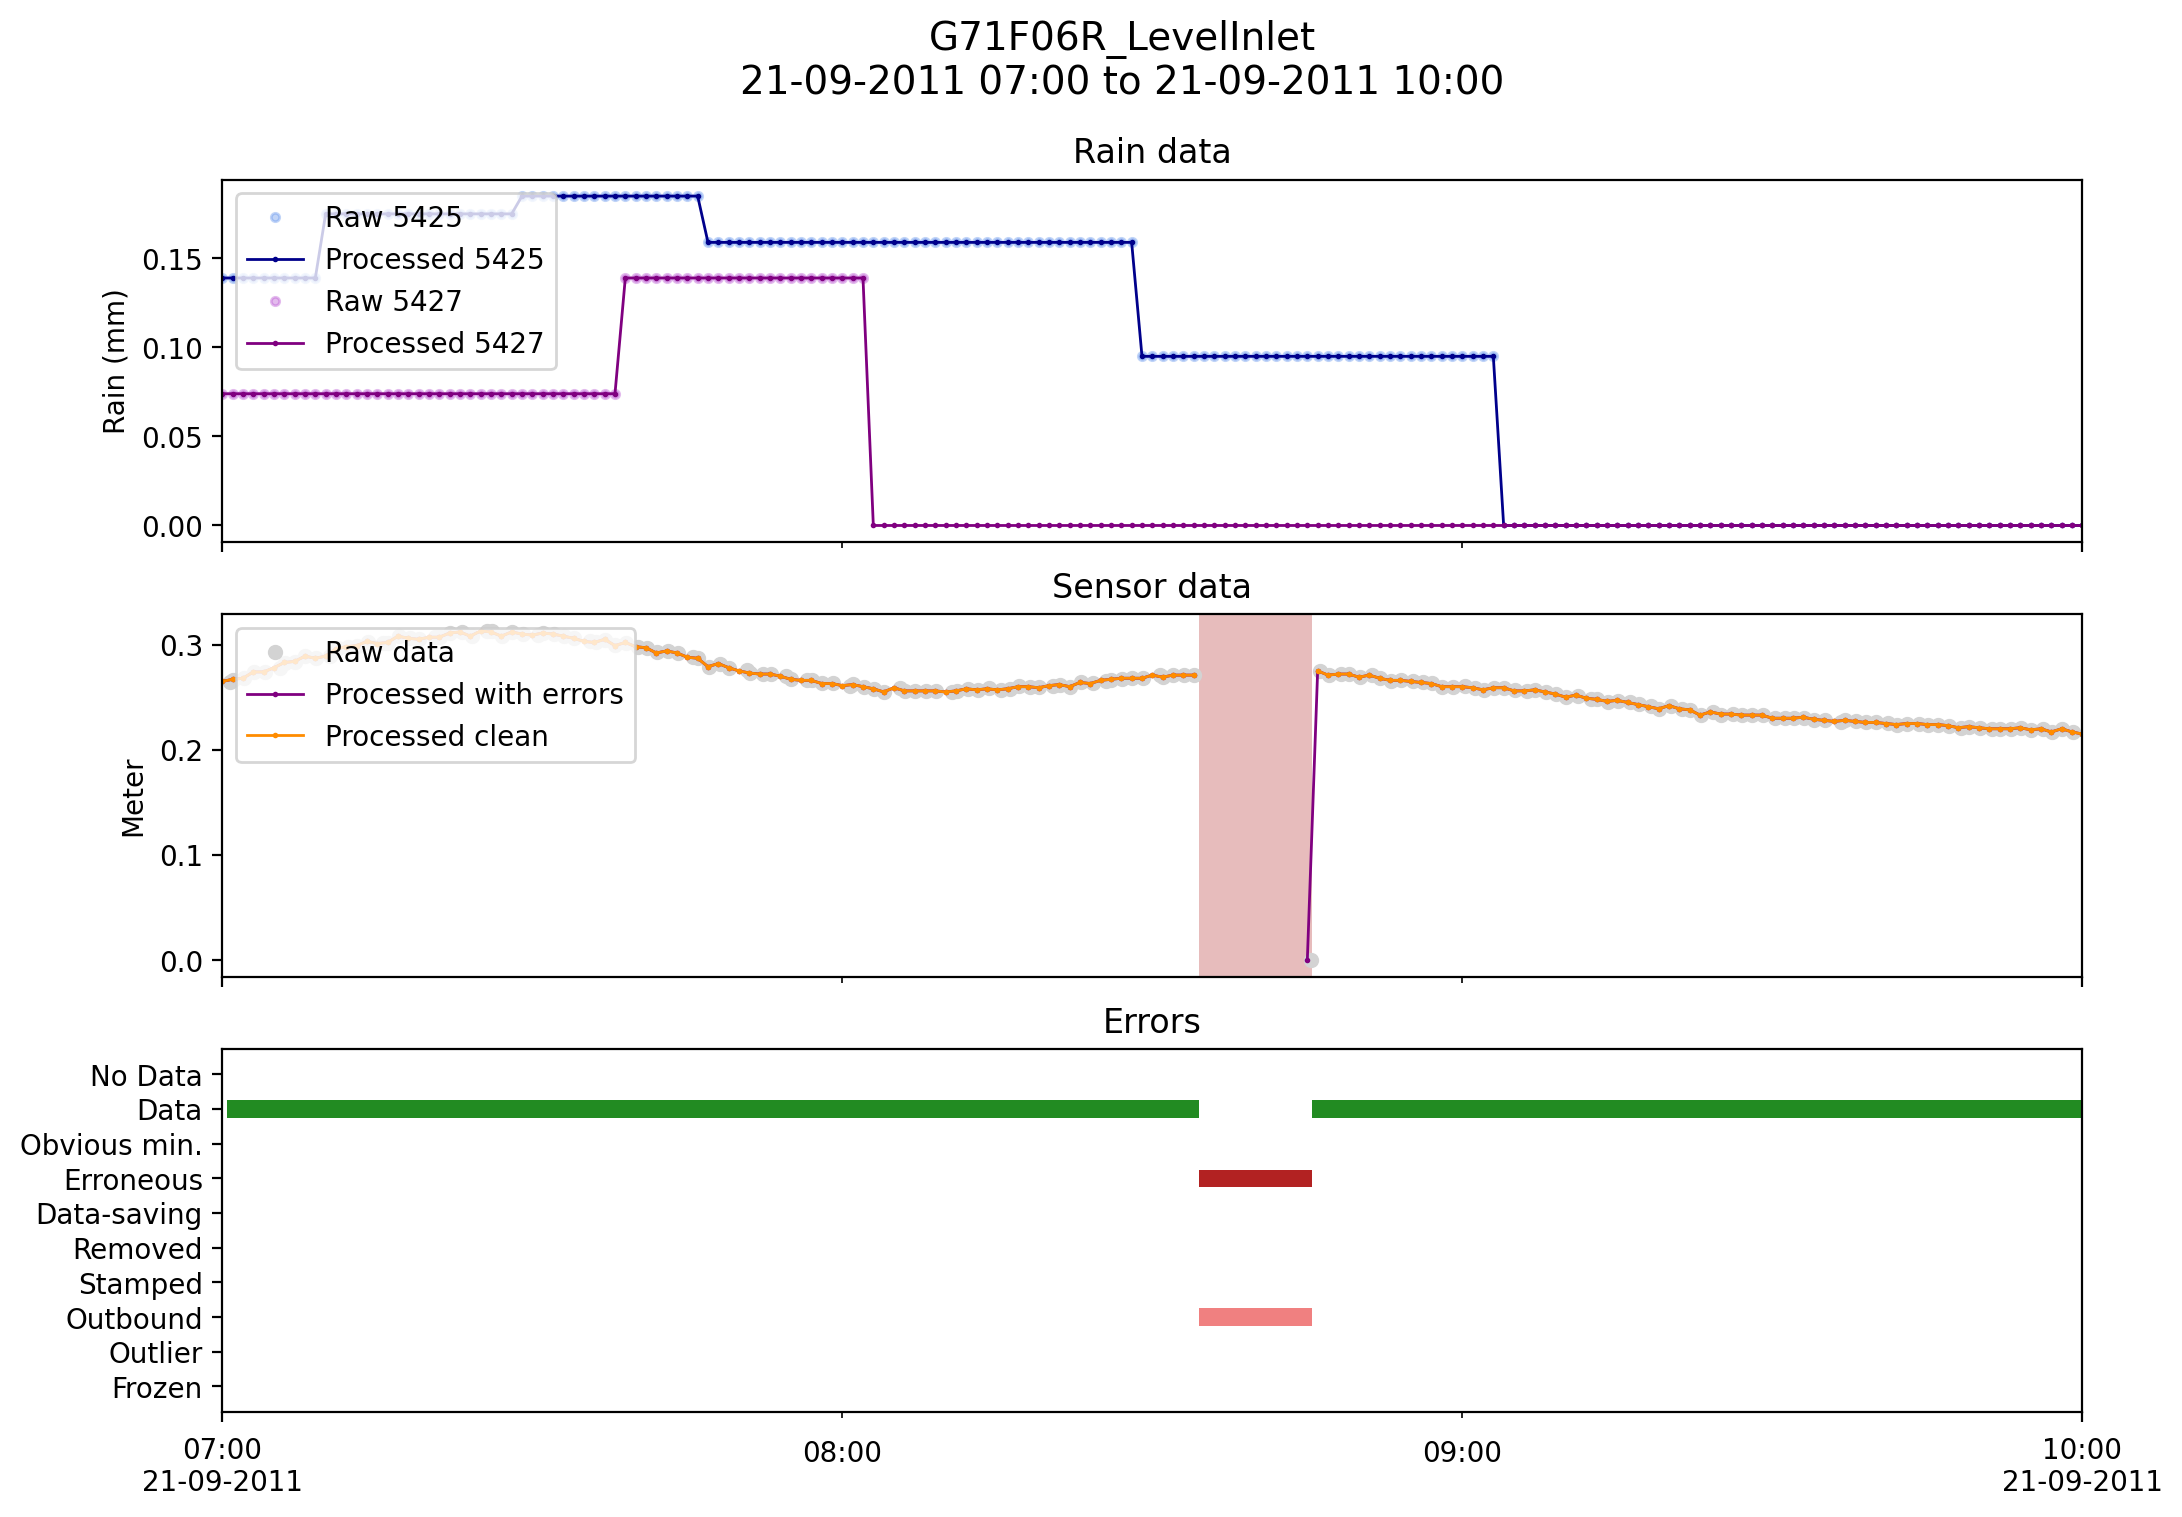

ValueError: Stop here

In [ ]:


_indicator_alias = 'Outbound'
date = pd.Timestamp('2011-09-21')


for indicator_alias, events in example_bools_events[sensor_name].items():

    if indicator_alias != _indicator_alias:
        # skip outbound
        continue

    for j, bools_event in enumerate(events):
        if bools_event['start'].date() != date.date():
            continue


        # get the start and end
        start, end = bools_event['start'], bools_event['end']
        # floor and ceil the start and end wrt hourly
        start, end = start.floor('H'), end.ceil('H')
        # go 2 hours back and 2 hours forward
        start, end = start - timedelta(hours=1), end + timedelta(hours=1)
        # filter the data based on the start and end
        _event_data, _individual_indicators, _provided_individual_indicators = filter_complete_sensor_data(start, end, event_data, individual_indicators, provided_individual_indicators)
        if _event_data is None:
            continue
        # visualize the event
        fig, axs = visualize_sensor_event(_event_data, _individual_indicators, sensor_name, unit, start, end)
        plt.show()
        raise ValueError('Stop here')
        # fig.savefig(indicator_folder / f'{start.strftime("%Y_%m_%d")}_event.png')
        # plt.close(fig)

        # if event_data['provided_processed'].empty:
        #     continue # go to next event
        # # visualize the comparison
        # fig, axs = compare_provided_adjusted(_event_data, _individual_indicators, _provided_individual_indicators, sensor_name, unit, start, end)
        # fig.savefig(indicator_folder / f'{start.strftime("%Y_%m_%d")}_comparison.png')
        # plt.close(fig)

        # # filter _individual_indicators based on subset_indicators
        # _individual_indicators = {indicator: _individual_indicators[indicator] for indicator in subset_indicators}
        # _provided_individual_indicators = {indicator: _provided_individual_indicators[indicator] for indicator in subset_indicators}
        # # visualize the comparison
        # figsize = (12, 9)
        # height_ratios = [2, 1, 0.1, 2, 1]
        # fig, axs = compare_provided_adjusted(_event_data, _individual_indicators, _provided_individual_indicators, sensor_name, unit, start, end,
        #     figsize=figsize, height_ratios=height_ratios
        #     )
        # fig.savefig(indicator_folder / f'{start.strftime("%Y_%m_%d")}_comparison_sub.png')
        # plt.close(fig)




In [ ]:
### System change events
if sensor_name not in system_change_events:
    print('    No system change events')
    continue

print('    System change events')

event_folder = sensor_folder / 'system_change'
event_folder.mkdir(exist_ok=True)

for event_name, event in system_change_events[sensor_name].items():
    # get the start and end
    start, end = event['start'], event['end']
    # floor and ceil the start and end wrt hourly
    start, end = start.floor('H'), end.ceil('H')
    from_system, to_system = event['from'], event['to']
    # filter the data based on the start and end
    _event_data, _individual_indicators, _provided_individual_indicators = filter_complete_sensor_data(start, end, event_data, individual_indicators, provided_individual_indicators)
    if _event_data is None:
        continue
    # visualize the event
    fig, axs = visualize_sensor_event(_event_data, _individual_indicators, sensor_name, unit, start, end)
    fig.savefig(event_folder / f'{start.strftime("%Y_%m_%d")}_{from_system}_to_{to_system}_event.png')
    plt.close(fig)

print('---------------------------------\n')
